<a href="https://colab.research.google.com/github/Euan-J-Austin/Analytics_and_Intelligence/blob/main/ProphetNotes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prophet

Forecasting

Predicting future traffic for Udemy Wiki page

Error is a part of prediction, trying to explain all variation will result in overfitting

Uses Stan, a probabilisitic programming language for statistical causal inference, writtin in C++

Built-in cross-validation

#Time series

Data for consecutive periods

Many concepts and algorithms dealing with time series e.g. Structural Time series which decomposes data, at least, down to  seasonality, trend, exogenous impacts (e.g. weather, economic sentiment), and error term

*y(t) = c(t) + s(t) + x(t) + ε* `

# Prophet's methodological framework

*y(t) = c(t) + s(t) + h(t) + x(t) + ε*

1. c(t) ... Trend
2. s(t) ... Seasonality
3. h(t) ... Holiday effects +
4. x(t) ... External regressors + (not same as holidays, only impacts the day itself)
5. ε ... error, to be minimised




# Udemy practice case study

In [ ]:
import numpy as np
import pandas as pd
from prophet import Prophet

# Data

In [ ]:
df = pd.read_csv('/content/Udemy_wikipedia_visits.csv')

In [ ]:
df.tail()

NameError: ignored

In [ ]:
df.describe()

,Udemy,Easter,Christmas,Black Friday
count,1827.000000,1827.000000,1827.000000,1827.000000
mean,943.068418,0.002737,0.002737,0.002737
std,531.341700,0.052256,0.052256,0.052256
min,209.000000,0.000000,0.000000,0.000000
25%,542.500000,0.000000,0.000000,0.000000
50%,832.000000,0.000000,0.000000,0.000000
75%,1175.000000,0.000000,0.000000,0.000000
max,2847.000000,1.000000,1.000000,1.000000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1827 entries, 0 to 1826
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Date          1827 non-null   object
 1   Udemy         1827 non-null   int64 
 2   Easter        1827 non-null   int64 
 3   Christmas     1827 non-null   int64 
 4   Black Friday  1827 non-null   int64 
dtypes: int64(4), object(1)
memory usage: 71.5+ KB


<Axes: >

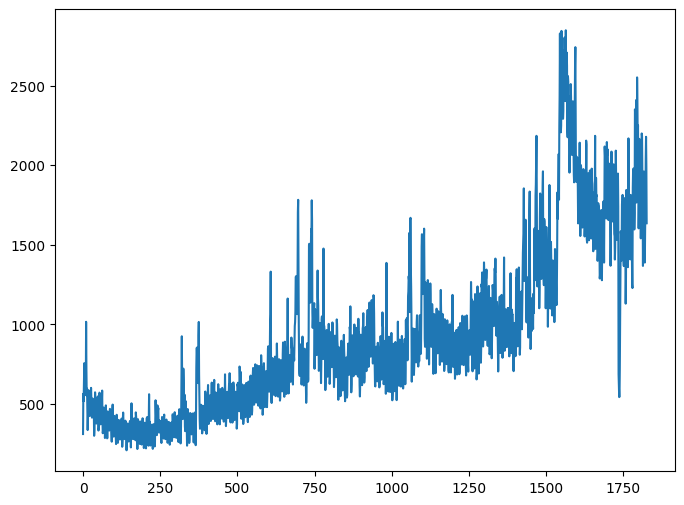

In [ ]:
df.Udemy.plot(figsize = (8, 6))

## Data formatting

### Date variable

In [ ]:
# %m/%d/%Y -- we want --> %Y-%m-%d
df.Date

0       01/01/2016
1       01/02/2016
2       01/03/2016
3       01/04/2016
4       01/05/2016
           ...    
1822    12/27/2020
1823    12/28/2020
1824    12/29/2020
1825    12/30/2020
1826    12/31/2020
Name: Date, Length: 1827, dtype: object

In [ ]:
df.Date = pd.to_datetime(df.Date,
                         format = '%m/%d/%Y')
df.Date

0      2016-01-01
1      2016-01-02
2      2016-01-03
3      2016-01-04
4      2016-01-05
          ...    
1822   2020-12-27
1823   2020-12-28
1824   2020-12-29
1825   2020-12-30
1826   2020-12-31
Name: Date, Length: 1827, dtype: datetime64[ns]

### Renaming variables

In [ ]:
#Date --> ds, ... time-series (Udemy) -> y

df = df.rename(columns = {'Date': 'ds',
                          'Udemy': 'y',
                          'Black Friday': 'BlackFriday'})
df.head(3)

,ds,y,Easter,Christmas,BlackFriday
0,2016-01-01,311,0,0,0
1,2016-01-02,564,0,0,0
2,2016-01-03,517,0,0,0


## Dynamic holidays

### Valentine's example

With Prophet, specify XXXX-02-14 as a key event and specifing days before and after

For other models, would have to create a dummy variable for each day

### Easter holiday

In [ ]:
easter_dates = df[df.Easter == 1].ds

In [ ]:
easter_dates

86     2016-03-27
471    2017-04-16
821    2018-04-01
1206   2019-04-21
1563   2020-04-12
Name: ds, dtype: datetime64[ns]

In [ ]:
easter = pd.DataFrame({
    'holiday': 'easter',
    'ds': easter_dates,
    'lower_window': -5,
    'upper_window': 2})

easter

,holiday,ds,lower_window,upper_window
86,easter,2016-03-27,-5,2
471,easter,2017-04-16,-5,2
821,easter,2018-04-01,-5,2
1206,easter,2019-04-21,-5,2
1563,easter,2020-04-12,-5,2


### Black Friday holiday

In [ ]:
blackfriday = pd.DataFrame({
    'holiday': 'BlackFriday',
    'ds': df[df.BlackFriday == 1].ds,
    'lower_window': -7,
    'upper_window': 5})

#Udemy's promotional period

In [ ]:
blackfriday

,holiday,ds,lower_window,upper_window
329,BlackFriday,2016-11-25,-7,5
693,BlackFriday,2017-11-24,-7,5
1057,BlackFriday,2018-11-23,-7,5
1428,BlackFriday,2019-11-29,-7,5
1792,BlackFriday,2020-11-27,-7,5


### Combining holidays' DataFrames

In [ ]:
holidays = pd.concat([easter, blackfriday])

In [ ]:
holidays

,holiday,ds,lower_window,upper_window
86,easter,2016-03-27,-5,2
471,easter,2017-04-16,-5,2
821,easter,2018-04-01,-5,2
1206,easter,2019-04-21,-5,2
1563,easter,2020-04-12,-5,2
329,BlackFriday,2016-11-25,-7,5
693,BlackFriday,2017-11-24,-7,5
1057,BlackFriday,2018-11-23,-7,5
1428,BlackFriday,2019-11-29,-7,5
1792,BlackFriday,2020-11-27,-7,5


### Remove holidays from DataFrame

In [ ]:
df = df.drop(columns = ['Easter', 'BlackFriday'])
df.head(0)

,ds,y,Christmas


# Training and Test sets in Time Series

Can't be randomly selected because days need to have context of the days surrounding

We want to predict the future, so focus wish to focus on most recent dates

So, early dates are used for training and most recent for test ...

You should be measured for the number of periods you wish to predict e.g. if predicting sales in 4 weeks, divide time series into 4 week periods

## Training and Test Split

In [ ]:
test_days = 31
training = df.iloc[:-test_days,:]
test = df.iloc[-test_days:,:]

In [ ]:
print(test.head(1))

             ds     y  Christmas
1796 2020-12-01  2393          0


In [ ]:
print(training.tail(1))

             ds     y  Christmas
1795 2020-11-30  2551          0


# Facebook Prophet Model

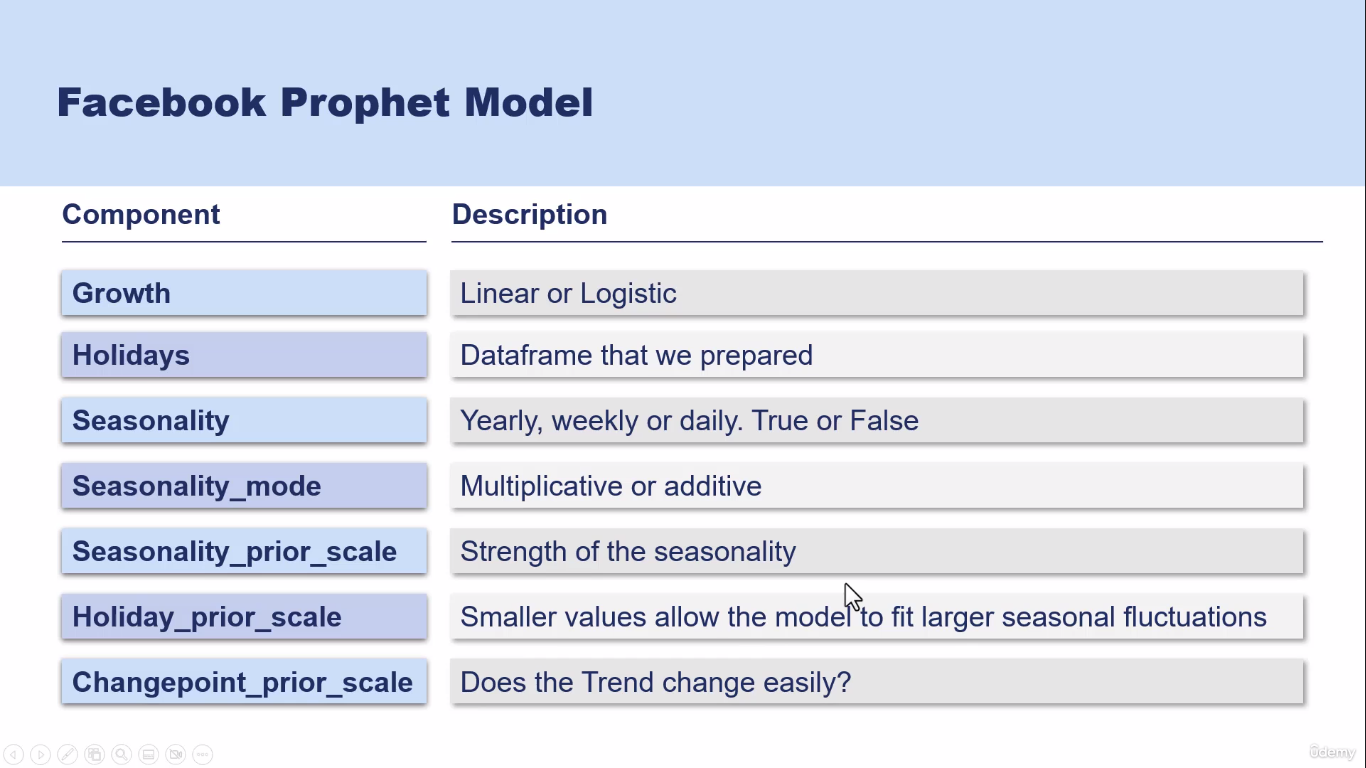

## Additive vs. Multiplicative Seasonality

There's no statistical test, so eyeball it.

Mulitplicative talks about seasonality in terms of percentage.

*y[t] = Tt[t] * S[t] * e[t]*

If we're talking about adding absolute values, then it is additive.

*y[t] = Tt[t] + S[t] + e[t]*

https://facebook.github.io/prophet/docs/multiplicative_seasonality.html ... additive is for when seasonality as a constant additive, whereas multiplicative is for when seasonality grows with a trend

## Building the model

### Create the model

In [ ]:
model = Prophet(growth = 'linear',
            yearly_seasonality = True,
            weekly_seasonality = True,
            daily_seasonality = False,
            holidays = holidays,
            seasonality_mode = 'additive',
            seasonality_prior_scale = 10,
            holidays_prior_scale = 10,
            changepoint_prior_scale = 0.05)

###  Fit the model to the data

In [ ]:
model.add_regressor('Christmas', mode = 'multiplicative') #holiday remaining in df

In [ ]:
model.fit(training)

DEBUG:cmdstanpy:input tempfile: /tmp/tmp8xuys0g9/yevz3q8b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8xuys0g9/6patyygm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15150', 'data', 'file=/tmp/tmp8xuys0g9/yevz3q8b.json', 'init=/tmp/tmp8xuys0g9/6patyygm.json', 'output', 'file=/tmp/tmp8xuys0g9/prophet_model9jt_dpss/prophet_model-20230618162727.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:27:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:27:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


### Regressor coefficients

In [ ]:
from prophet.utilities import regressor_coefficients
regressor_coefficients(model)

,regressor,regressor_mode,center,coef_lower,coef,coef_upper
0,Christmas,multiplicative,0.0,-0.324999,-0.324999,-0.324999


'At Christmas, the number of visits drops by 238.56.'

In [ ]:
regressor_coefficients(model)

,regressor,regressor_mode,center,coef_lower,coef,coef_upper
0,Christmas,multiplicative,0.0,-0.324999,-0.324999,-0.324999


'At Christmas, the number of visits drops 29%.'

### Forecasting

In [ ]:
#create future dataframe
future = model.make_future_dataframe(periods = test_days,
                            freq = 'D')

In [ ]:
future  = pd.concat([future, df.iloc[:,2:]],
                    axis = 1)
#index 2 as 0 is datestamp and 1 is y

In [ ]:
future.tail(7)

,ds,Christmas
1820,2020-12-25,1
1821,2020-12-26,0
1822,2020-12-27,0
1823,2020-12-28,0
1824,2020-12-29,0
1825,2020-12-30,0
1826,2020-12-31,0


In [ ]:
forecast = model.predict(future)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,BlackFriday,BlackFriday_lower,BlackFriday_upper,Christmas,...,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,yhat
0,2016-01-01,308.976369,187.469843,703.053415,308.976369,308.976369,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-22.264241,-22.264241,-22.264241,145.851107,145.851107,145.851107,432.563235
1,2016-01-02,309.315141,39.623871,536.204882,309.315141,309.315141,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-180.805727,-180.805727,-180.805727,169.664368,169.664368,169.664368,298.173782
2,2016-01-03,309.653914,117.185651,600.150279,309.653914,309.653914,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-140.666865,-140.666865,-140.666865,192.259566,192.259566,192.259566,361.246614
3,2016-01-04,309.992686,345.447595,837.810964,309.992686,309.992686,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,75.578074,75.578074,75.578074,213.279828,213.279828,213.279828,598.850589
4,2016-01-05,310.331459,403.929097,902.588054,310.331459,310.331459,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,102.280183,102.280183,102.280183,232.395892,232.395892,232.395892,645.007534


In [ ]:
print(forecast.columns)

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'BlackFriday', 'BlackFriday_lower', 'BlackFriday_upper', 'Christmas',
       'Christmas_lower', 'Christmas_upper', 'additive_terms',
       'additive_terms_lower', 'additive_terms_upper', 'easter',
       'easter_lower', 'easter_upper', 'extra_regressors_multiplicative',
       'extra_regressors_multiplicative_lower',
       'extra_regressors_multiplicative_upper', 'holidays', 'holidays_lower',
       'holidays_upper', 'multiplicative_terms', 'multiplicative_terms_lower',
       'multiplicative_terms_upper', 'weekly', 'weekly_lower', 'weekly_upper',
       'yearly', 'yearly_lower', 'yearly_upper', 'yhat'],
      dtype='object')


### Event assessment

In [ ]:
#Holiday assessment
holiday = 'easter'
forecast[(forecast[holiday].abs() > 0) & (forecast['ds'] > '2020-01-01')][['ds', holiday]]

,ds,easter
1558,2020-04-07,-18.993106
1559,2020-04-08,-35.736113
1560,2020-04-09,4.146769
1561,2020-04-10,30.012789
1562,2020-04-11,73.832105
1563,2020-04-12,85.305515
1564,2020-04-13,85.029641
1565,2020-04-14,27.751958


In [ ]:
#Holiday assessment
holiday = 'BlackFriday'
forecast[(forecast[holiday].abs() > 0) & (forecast['ds'] > '2020-01-01')][['ds', holiday]]

,ds,BlackFriday
1785,2020-11-20,99.296527
1786,2020-11-21,90.540009
1787,2020-11-22,163.347479
1788,2020-11-23,235.617435
1789,2020-11-24,212.007264
1790,2020-11-25,184.124600
1791,2020-11-26,223.389001
1792,2020-11-27,447.508542
1793,2020-11-28,204.173744
1794,2020-11-29,228.853817


### Accuracy assessment

In [ ]:
#Retrive the predictions

predictions = forecast.yhat[-test_days:]

In [ ]:
#Accuracy assessment
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [ ]:
print(mean_absolute_error(test.y, predictions))
print(np.sqrt(mean_squared_error(test.y, predictions)))

184.5327309354843
236.18722269520234


MAE for stakeholders, MSE for tuning.

### Visualization

In [ ]:
#Visualize the forecast

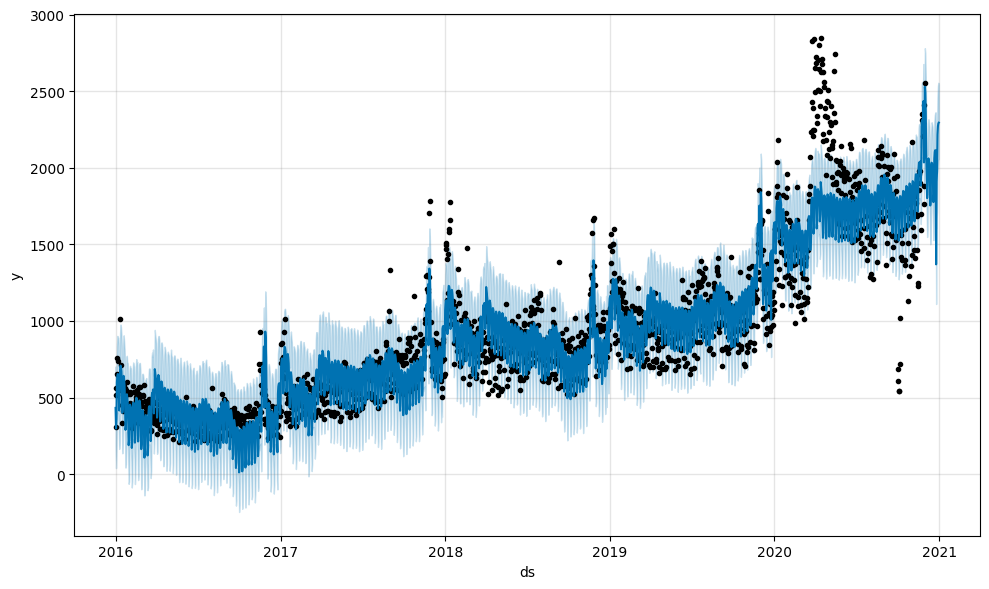

In [ ]:
model.plot(forecast);

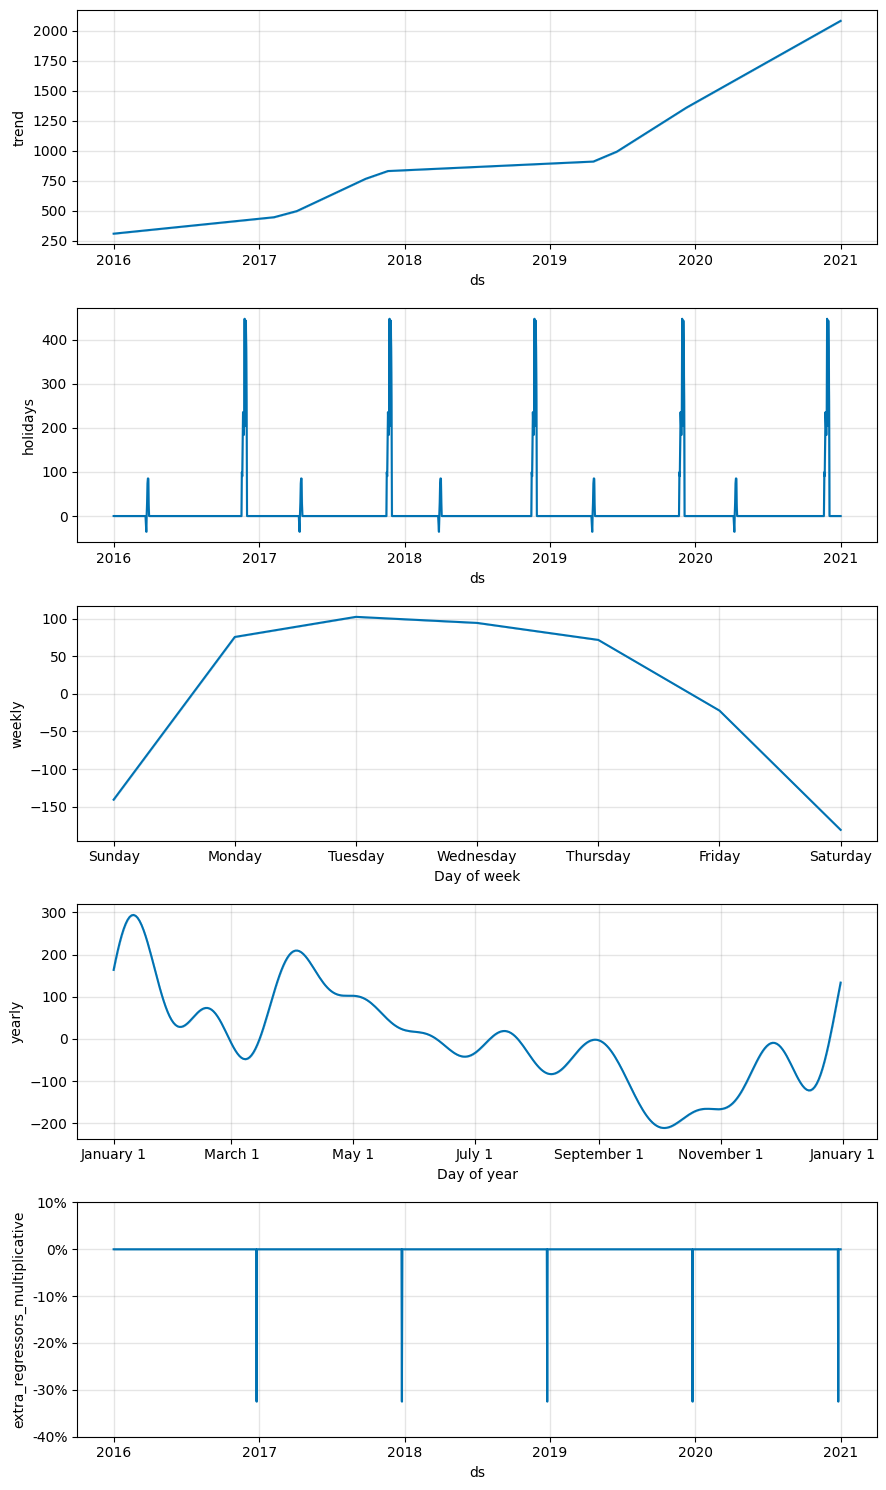

In [ ]:
#plot components -> Structural Time Series decomposition
model.plot_components(forecast);

### Cross-validation

Repeating the assessment of our model reinforces it's evaluation.

Cross-validation mixes training and test sets, adding test to training and running that same test data etc.

In [ ]:
#CV
from prophet.diagnostics import cross_validation
df_cv = cross_validation(model,
                 horizon = '31 days',
                 initial = '1450 days', #1827-about a yr
                 parallel = 'processes')

In [ ]:
df_cv.head()
#yhat is prediction, y is actual

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2019-12-26,1283.904639,1142.877514,1412.281150,1165,2019-12-25
1,2019-12-27,1225.347896,1094.660816,1356.517783,1111,2019-12-25
2,2019-12-28,1104.061400,971.563305,1240.243514,1038,2019-12-25
3,2019-12-29,1165.969900,1031.055254,1305.015355,971,2019-12-25
4,2019-12-30,1374.564180,1241.405151,1504.622551,1192,2019-12-25


In [ ]:
#Error assessment
print(mean_absolute_error(df_cv['y'], df_cv['yhat']))
print(np.sqrt(mean_squared_error(df_cv['y'], df_cv['yhat'])))

397.58625790524655
515.3769002846452


In [ ]:
from prophet.plot import plot_cross_validation_metric

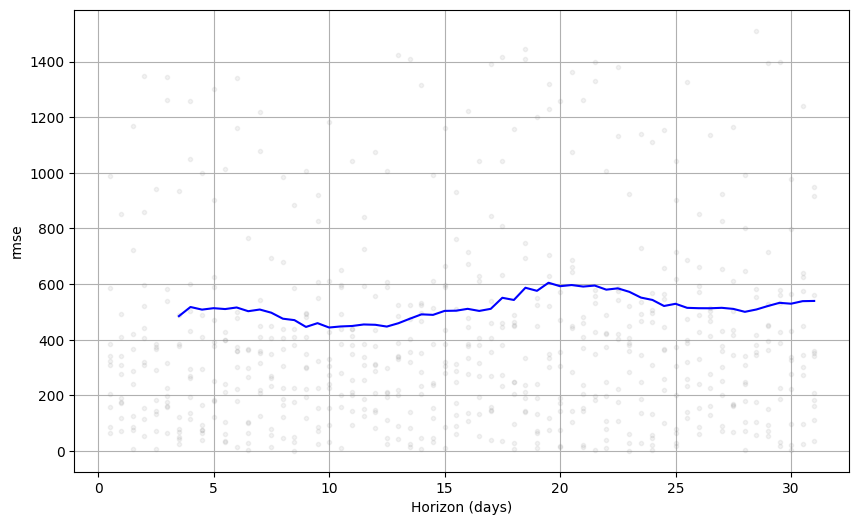

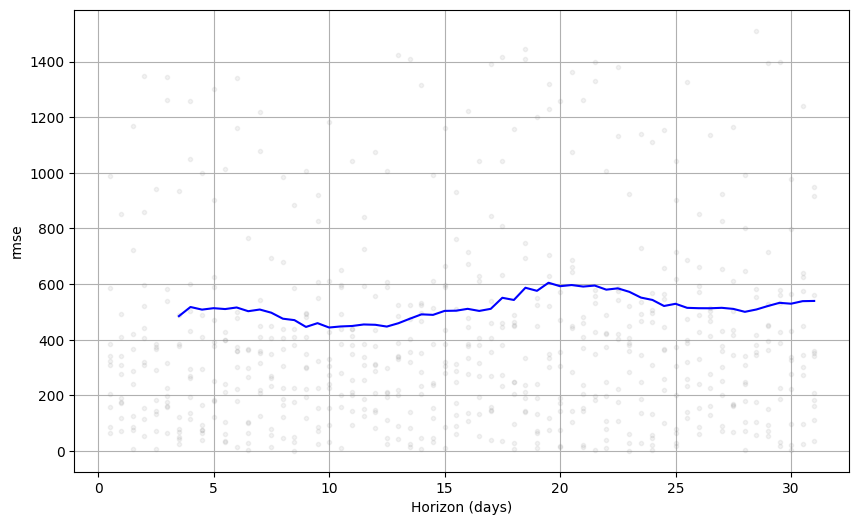

In [ ]:
plot_cross_validation_metric(df_cv,
                             metric = 'rmse')

Forecast accuracy is relatively stable, upward trend as further into future is higher uncertainty

### Parameter tuning

Improves accuracy and reliability but from a business interpretation perspective it doesn't tell us much.

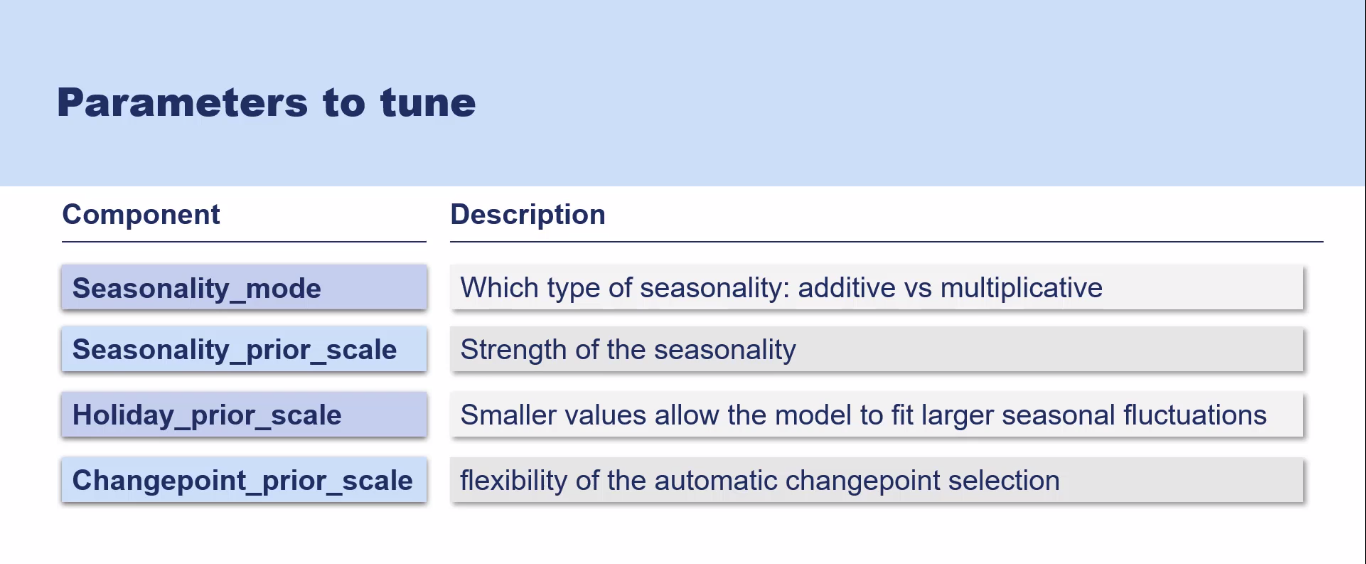

#### Parameter grid

In [ ]:
from sklearn.model_selection import ParameterGrid

In [ ]:
param_grid = {'seasonality_mode': ['additive', 'multiplicative'],
              'seasonality_prior_scale': [5, 10, 20],
              'holidays_prior_scale': [5, 10, 20],
              'changepoint_prior_scale': [0.01, 0.05, 0.1]}
grid = ParameterGrid(param_grid)
list(grid)

In [ ]:
#Empty list to store results
rmse = []
#start the loop
for params in grid:
  #build the model
  m = Prophet(growth = 'linear',
            yearly_seasonality = True,
            weekly_seasonality = True,
            daily_seasonality = False,
            holidays = holidays,
            seasonality_mode = params['seasonality_mode'],
            seasonality_prior_scale = params['seasonality_prior_scale'],
            holidays_prior_scale = params['holidays_prior_scale'],
            changepoint_prior_scale= params['changepoint_prior_scale'])
  m.add_regressor('Christmas', mode = 'multiplicative')
  m.fit(training)

  #Cross-Validation
  df_cv = cross_validation(m,
                           horizon = '31 days',
                           initial = '1450 days',
                           parallel = 'processes')

  #Measure and store results
  error = np.sqrt(mean_squared_error(df_cv['y'], df_cv['yhat']))
  rmse.append(error)

In [ ]:
#Get the best parameters
tuning_results = pd.DataFrame(grid)
tuning_results['rmse'] = rmse
tuning_results.min()

changepoint_prior_scale         0.01
holidays_prior_scale               5
seasonality_mode            additive
seasonality_prior_scale            5
rmse                       448.92243
dtype: object

Now can amend parameters, test out more values for parameter tuning to decrease error.